In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_fixed_radius"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 1.5

NUM_DATASETS, N, D = Data.shape
K = 4 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 32
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 100
LEARNING_RATE = 5 * 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-final'
DEVICE = torch.device('cuda:0')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D)

In [3]:
from local_enc_mu import *
from global_oneshot_mu_v1 import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
from os_ep import *
enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
oneshot_eta.load_state_dict(torch.load("../weights/oneshot-eta-%s" % PATH))
# train_baseline(models, EP, optimizer, Data, Model_Params, Train_Params)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
# torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
# torch.save(oneshot_eta.state_dict(), "../weights/oneshot-eta-%s" % PATH)

In [7]:
BATCH_SIZE_TEST = 5
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_mu, _, q_z, _) = reused

CPU times: user 1.4 s, sys: 12 ms, total: 1.41 s
Wall time: 1.41 s


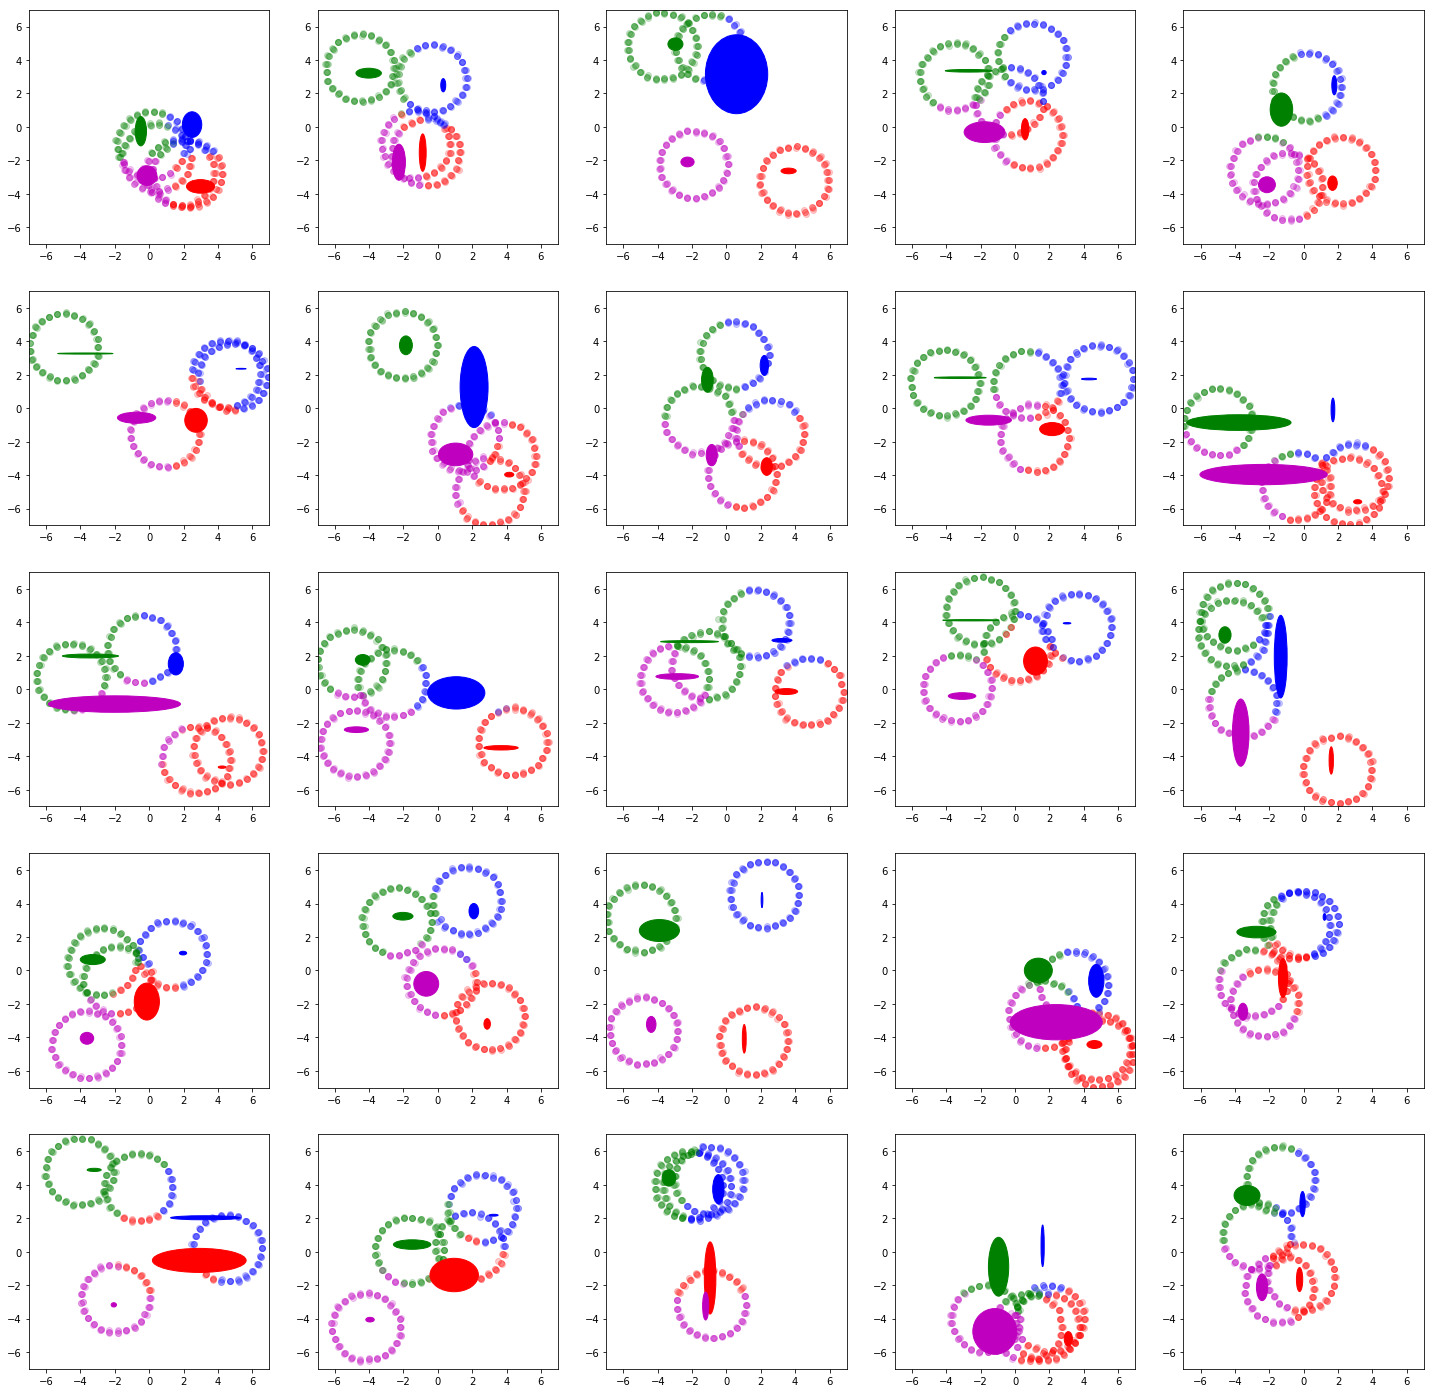

In [8]:
%time plot_samples(obs, q_mu, q_z, K, PATH)